## Cài đặt thư viện

In [2]:
import os
import numpy as np
import librosa
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

## 1. Tiền xử lý dữ liệu

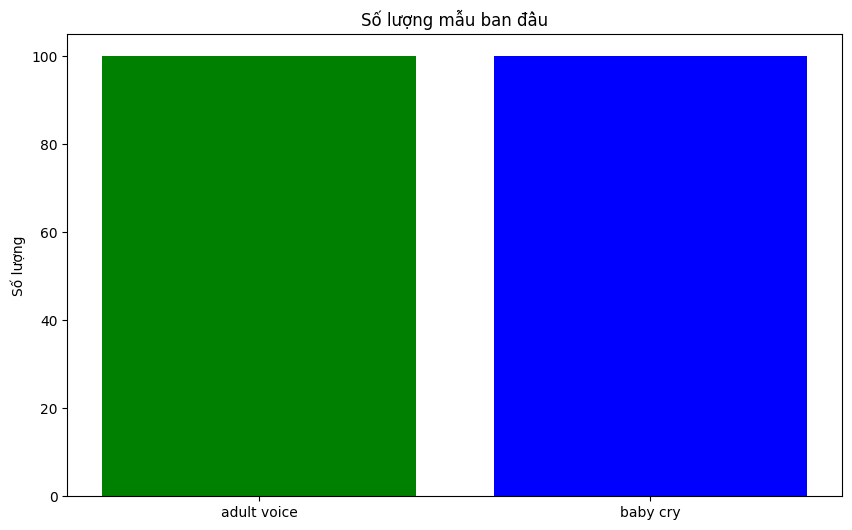

In [3]:
rebalanced_dataset_dir = 'data'
# Đếm số lượng file trong mỗi thư mục (ứng với mỗi class)
rebalance_class_counts = {}
for class_folder in os.listdir(rebalanced_dataset_dir):
    class_path = os.path.join(rebalanced_dataset_dir, class_folder)
    if os.path.isdir(class_path):
        num_files = len(os.listdir(class_path))
        rebalance_class_counts[class_folder] = num_files

# Vẽ biểu đồ cột
labels = list(rebalance_class_counts.keys())
counts = list(rebalance_class_counts.values())
colors = ['green', 'blue']
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=colors)

plt.ylabel('Số lượng')
plt.title('Số lượng mẫu ban đầu')
plt.show()

In [4]:
baby_cry_path = 'data/baby cry'
adult_voice_path = 'data/adult voice'

# Hàm chuẩn hóa thời gian âm thanh về 7 giây
def normalize_audio_length(y, sr, target_duration=7):
    target_length = sr * target_duration  # Số lượng mẫu tương ứng với 7 giây
    if len(y) > target_length:
        # Cắt ngắn tín hiệu nếu dài hơn 7 giây
        y = y[:target_length]
    elif len(y) < target_length:
        # Padding nếu tín hiệu ngắn hơn 7 giây
        padding = target_length - len(y)
        y = np.pad(y, (0, padding), 'constant')
    return y

## 2. Trích xuất đặc trưng

In [5]:
# Hàm trích xuất đặc trưng Spectrogram sử dụng cửa sổ Hamming
def extract_spectrogram_features(y, sr, n_fft=2048, hop_length=512):
    # Áp dụng cửa sổ Hamming
    window = np.hamming(n_fft)
    # Tính Spectrogram
    spectrogram = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window))**2
    # Chuyển đổi sang dB
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram_db

In [6]:
features_list = []
labels_list = []
#  Hàm xử lý file âm thanh trong thư mục và trích xuất Spectrogram
def process_directory(directory, label, sr=16000, target_duration=7):
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            file_path = os.path.join(directory, filename)
            y, sr = librosa.load(file_path, sr=sr)
            y = normalize_audio_length(y, sr, target_duration)
            features = extract_spectrogram_features(y, sr)
            features_list.append(features)
            labels_list.append(label)
    return features_list, labels_list

In [8]:
# Xử lý các tệp âm thanh trong thư mục
process_directory(baby_cry_path, 'Baby Cry')
process_directory(adult_voice_path, 'Adult Voice')

# # Chuyển đổi danh sách thành mảng numpy và
# # Chuẩn hóa tất cả các vector đặc trưng về cùng độ dài để có thể đưa vào mô hình học máy
# max_len = max(len(feature) for feature in features_list)
# X = np.zeros((len(features_list), max_len))

# for i, feature in enumerate(features_list):
#     X[i, :len(feature)] = feature
#     print(len(X))

# Chuyển đổi danh sách thành mảng numpy và chuẩn hóa kích thước
num_features = features_list[0].shape[0] * features_list[0].shape[1]
print(num_features)
X = np.array([feature.reshape(num_features) for feature in features_list])
print(X.shape)

# Chuẩn hóa đặc trưng với StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Mã hóa nhãn
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels_list)

224475
(400, 224475)


## 3. Huấn luyện mô hình

In [9]:
# Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# Danh sách các mô hình để thử nghiệm
models = {
    'K-Neighbors Classifier': KNeighborsClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'XGBClassifier': XGBClassifier(eval_metric='mlogloss')
}

results = []
for model_name, model in models.items():
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
    # Train the model on the training data
    model.fit(X_train, y_train)
    # Make predictions on the test data
    y_pred = model.predict(X_test)  # Define y_pred here
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate F1 score (weighted)
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Print and store results
    print(f"Model: {model_name}, Accuracy: {accuracy:.2f}, F1 score: {scores.mean():.4f}")
    results.append({'Algorithm': model_name, 'Accuracy Score': accuracy, 'F1 Score': f1})

# Chuyển kết quả sang DataFrame
results_df = pd.DataFrame(results)

# Hiển thị bảng kết quả
print(results_df)

# Vẽ biểu đồ độ chính xác
plt.figure(figsize=(10, 5))
plt.bar(results_df['Algorithm'], results_df['F1 Score'], color='skyblue')
plt.title('Model Performance Comparison')
plt.ylabel('F1 score')
plt.xticks(rotation=45)
plt.show()

### Tối ưu hóa tham số mô hình Random Forest (RF)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {'n_estimators': [50, 100, 200, 300, 400],
#               'max_depth': [None, 10, 20, 30, 40, 50],
#               'max_features': ['sqrt', 'log2'],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap': [True, False],
#               'criterion': ['gini', 'entropy']
#              }
# grid_search = RandomizedSearchCV (RandomForestClassifier(), param_grid, n_iter=100, cv=5, scoring='f1_weighted')
# grid_search.fit(X_train, y_train)
# print("Best parameters: ", grid_search.best_params_)

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# # Khởi tạo mô hình với các siêu tham số tốt nhất
# best_params = {'n_estimators': 300,
#                'min_samples_split': 5,
#                'min_samples_leaf': 1,
#                'max_features': 'log2',
#                'max_depth': 50,
#                'criterion': 'gini',
#                'bootstrap': False}

# model = RandomForestClassifier(**best_params)

# # Huấn luyện mô hình
# model.fit(X_train, y_train)

# # Dự đoán trên tập kiểm tra
# y_pred = model.predict(X_test)

# # Đánh giá mô hình
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred, average='weighted')

# print(f"Accuracy: {accuracy} F1 Score: {f1}")

### Lưu mô hình

In [ ]:
# import joblib

# model_filename = 'randomforest_model.pkl'

# # Lưu mô hình
# joblib.dump(model, model_filename)

# print(f"Mô hình đã được lưu thành công tại {model_filename}")

### Tải mô hình

In [ ]:
# # Tải mô hình đã lưu
# loaded_model = joblib.load(model_filename)

# # Sử dụng mô hình để dự đoán
# y_pred = loaded_model.predict(X_test)

# print("Mô hình đã được tải và sẵn sàng sử dụng.")

In [ ]:
# # Tính accuracy
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred, average='weighted')
# print(f"               Algorithm  Accuracy Score  F1 Score")
# print(f"Random Forest Classifier        {accuracy:.6f}  {f1:.6f}")


### Ma trận nhầm lẫn

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Tính toán ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)

# Chuyển đổi ma trận nhầm lẫn thành tỷ lệ phần trăm
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Hiển thị ma trận nhầm lẫn dưới dạng phần trăm
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('True label')
plt.xlabel('Predict label')
plt.show()